http://github.com/dancoe/ceers

Analyzing simulated NIRCam images from  
CEERS SDR3: Simulated Data Release 3   
https://ceers.github.io/sdr3.html  
NIRCam images in 6 filters: F115W F150W F200W F277W F356W F444W  
0.03" / pixel image reductions (native SW ~0.03", LW ~0.06")  

In [1]:
import numpy as np
import os
from glob import glob
from copy import deepcopy
from os.path import expanduser
home = expanduser("~")
from packaging import version

import astropy  # version 4.2 is required to write magnitudes to ecsv file
from astropy.io import fits
import astropy.wcs as wcs
from astropy.table import QTable, Table
import astropy.units as u
from astropy.visualization import make_lupton_rgb, SqrtStretch, LogStretch, hist, simple_norm
from astropy.visualization.mpl_normalize import ImageNormalize
from astropy.convolution import Gaussian2DKernel
from astropy.stats import gaussian_fwhm_to_sigma
from astropy.coordinates import SkyCoord

In [2]:
import matplotlib
import matplotlib.pyplot as plt
from matplotlib import ticker
#%matplotlib inline   # non-interactive (easier for notebook scrolling)
%matplotlib notebook
#plt.style.use(os.path.join(home, 'p', 'matplotlibrc.txt')) # https://matplotlib.org/tutorials/introductory/customizing.html
plt.style.use('https://www.stsci.edu/~dcoe/matplotlibrc.txt') # https://matplotlib.org/tutorials/introductory/customizing.html
mpl_colors = plt.rcParams['axes.prop_cycle'].by_key()['color']

In [3]:
# Show versions of Python and imported libraries
try:
    import watermark
    %load_ext watermark
    # %watermark -n -v -m -g -iv
    %watermark -iv -v
except ImportError:
    pass

Python implementation: CPython
Python version       : 3.10.4
IPython version      : 8.4.0

matplotlib: 3.5.2
packaging : 21.3
numpy     : 1.22.4
watermark : 2.3.1
astropy   : 5.1



# Show Photutils output catalog detections

In [4]:
# Catalog: ecsv format preserves units for loading in Python notebooks
field = 'ceers5'
#output_catalog_file = field + '_photometry.cat'
#output_catalog_file = os.path.join('../phot', output_catalog_file)
output_catalog_file = field + '_phot-eazy.cat'
output_catalog_file = os.path.join('../eazy3', output_catalog_file)
output_catalog = astropy.io.ascii.read(output_catalog_file)

In [5]:
# Reconstitute filter list
filters = []
for param in output_catalog.columns:
    if param[-4:] == '_mag':
        filters.append(param[:-4])
        
wavelengths = np.array([int(filt[1:4]) / 100 for filt in filters]) * u.um  # e.g., F115W = 1.15 microns

In [6]:
image_file = '../images/ceers5_f200w_sci.fits.gz'
image_hdu_list = fits.open(image_file)
idata = 1  # fits extension where data lives
image_data = image_hdu_list[idata].data
imwcs = wcs.WCS(image_hdu_list[idata].header, image_hdu_list)

<IPython.core.display.Javascript object>


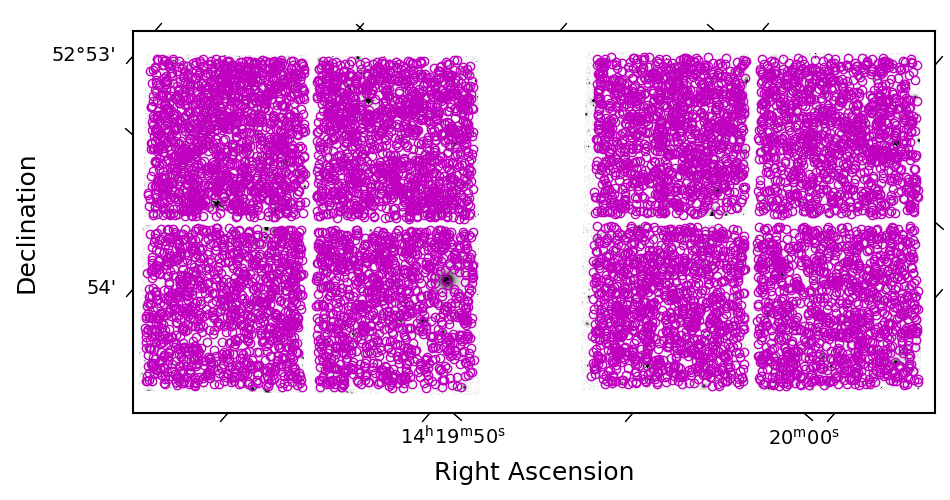

In [7]:
fig = plt.figure(figsize=(9.5, 5))
ax = fig.add_subplot(1, 1, 1, projection=imwcs) # , sharex=True, sharey=True)
norm = ImageNormalize(stretch=SqrtStretch(), vmin=0, vmax=0.5)
plt.imshow(image_data, origin='lower', norm=norm, interpolation='none', cmap='Greys')
plt.xlabel('Right Ascension')
plt.ylabel('Declination')
plt.plot(output_catalog['ra'], output_catalog['dec'], 'mo', mfc='None', transform=ax.get_transform('world'))

# Signal-to-Noise vs. magnitude

<IPython.core.display.Javascript object>


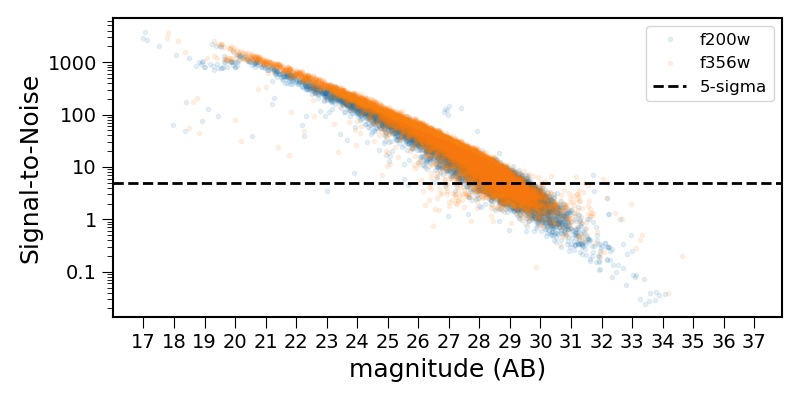

/var/folders/y3/vsjr6j554mnfpgy_m1xrnckm0003tz/T/ipykernel_26868/2078884148.py:10: RuntimeWarning: divide by zero encountered in true_divide
  SNR = flux / fluxerr
/var/folders/y3/vsjr6j554mnfpgy_m1xrnckm0003tz/T/ipykernel_26868/2078884148.py:10: RuntimeWarning: invalid value encountered in true_divide
  SNR = flux / fluxerr


In [54]:
from matplotlib.ticker import ScalarFormatter, FuncFormatter, MultipleLocator

fig, ax = plt.subplots(figsize=(8,4))

#for filt in filters:
filts2plot = 'f200w f356w'.split()
for filt in filts2plot:
    flux = output_catalog[filt+'_flux']
    fluxerr = output_catalog[filt+'_fluxerr']
    SNR = flux / fluxerr
    #mag = flux.to(u.ABmag)
    mag = output_catalog[filt+'_mag']
    good = between(0, mag, 90)
    mag    = mag[good]
    SNR = SNR[good]
    plt.plot(mag, SNR, '.', alpha=0.1, label=filt)

plt.axhline(5, c='k', ls='--', label='5-sigma')

#plt.xlim(28,34)
#plt.ylim(1,15)

plt.xlabel('magnitude (AB)')
plt.ylabel('Signal-to-Noise')
plt.semilogy()
plt.yscale('log')
formatter = FuncFormatter(lambda y, _: '{:.16g}'.format(y))
ax.yaxis.set_major_formatter(formatter)
ax.xaxis.set_major_locator(MultipleLocator(1))

#secax = ax.secondary_xaxis('top', functions=(AB2nJy, nJy2AB))
#secax.set_xlabel('Flux (nJy)')

plt.legend();
plt.savefig('SNR_vs_mag_%s_%s.png' % tuple(filts2plot))

# Show input catalog objects

In [9]:
input_catalog_file = '../inputs/CEERS_SDR3_SAM_input.fits'
complete_input_catalog = Table.read(input_catalog_file)

In [10]:
def between(lo, x, hi, tol=0):
    return (lo-tol < x) & (x < hi+tol)

In [11]:
tolerance = 0.001  # allow for edge objects: 0.001 deg ~3.6" sort of (depends on dec)
ra_good = between( min(output_catalog['ra']),  complete_input_catalog['ra'],  max(output_catalog['ra']),  tolerance)
dec_good = between(min(output_catalog['dec']), complete_input_catalog['dec'], max(output_catalog['dec']), tolerance)
all_good = ra_good * dec_good

In [12]:
input_catalog = complete_input_catalog[all_good]

In [13]:
len(input_catalog)

51528

<IPython.core.display.Javascript object>


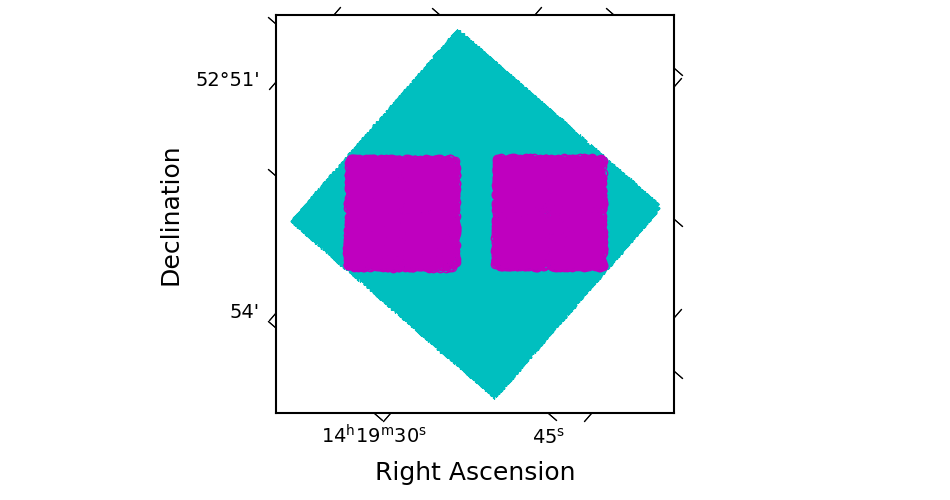

In [14]:
fig = plt.figure(figsize=(9.5, 5))
ax = fig.add_subplot(1, 1, 1, projection=imwcs) # , sharex=True, sharey=True)
norm = ImageNormalize(stretch=SqrtStretch(), vmin=0, vmax=0.5)
plt.imshow(image_data, origin='lower', norm=norm, interpolation='none', cmap='Greys')
plt.xlabel('Right Ascension')
plt.ylabel('Declination')
plt.plot(input_catalog['ra'],  input_catalog['dec'],  'c+', mfc='None', transform=ax.get_transform('world'))
plt.plot(output_catalog['ra'], output_catalog['dec'], 'mo', mfc='None', transform=ax.get_transform('world'))

# Match input objects to output photutils catalog

In [16]:
# Match input objects to output photutils catalog
# https://docs.astropy.org/en/stable/coordinates/matchsep.html
# Note ra, dec need to have units e.g., u.deg
input_coordinates = SkyCoord(ra=input_catalog['ra']*u.deg, dec=input_catalog['dec']*u.deg)
# Can use output_catalog['sky_centroid'] if saved in table, but this demo saved (ra,dec) instead:
detected_coordinates = SkyCoord(ra=output_catalog['ra']*u.deg, dec=output_catalog['dec']*u.deg)
input_match_indices, separation2d, distance3d = detected_coordinates.match_to_catalog_sky(input_coordinates)

<IPython.core.display.Javascript object>


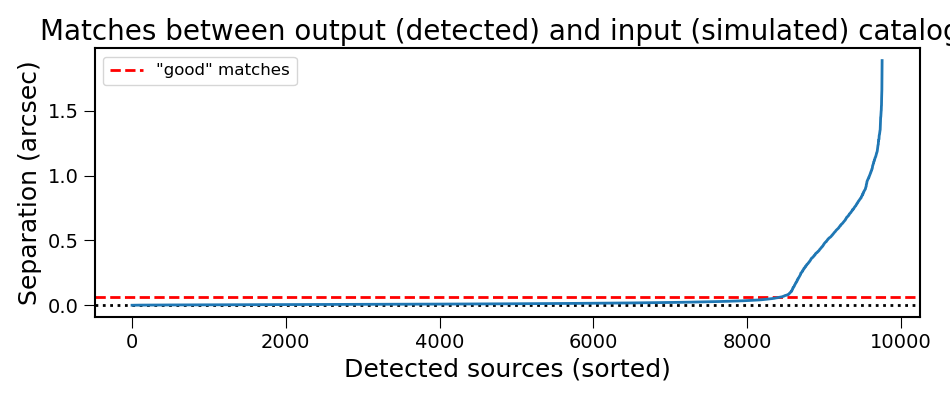

In [17]:
fig = plt.figure(figsize=(9.5, 4))
plt.rc('font', size=12)   
plt.plot(np.sort(separation2d.to(u.arcsec)), zorder=10)
separation_max = 0.06 * u.arcsec  # determined by eye after plotting
plt.axhline(0, c='k', ls=':')
plt.axhline(separation_max.value, c='r', ls='--', label='"good" matches')
plt.title('Matches between output (detected) and input (simulated) catalogs')
plt.xlabel('Detected sources (sorted)')
plt.ylabel('Separation (arcsec)')
plt.legend()

In [18]:
good_matches = separation2d < separation_max
unique_matches, index_counts = np.unique(input_match_indices[good_matches], return_counts=True)

print('%d matches (%d unique) between input catalog (%d galaxies) and photutils catalog (%d detected sources)'
      % (np.sum(good_matches), len(unique_matches), len(input_catalog), len(output_catalog)))

multiple_matches = unique_matches[index_counts > 1]
if len(multiple_matches):
    print('Input sources matched multiple times:', list(output_catalog['id'][multiple_matches]))

8407 matches (8407 unique) between input catalog (51528 galaxies) and photutils catalog (9755 detected sources)


In [19]:
#input_catalog_matched  = input[input_match_indices][good_matches]
input_catalog_matched  = input_catalog[input_match_indices][good_matches]
output_catalog_matched = output_catalog[good_matches]

# Save matched catalogs

In [ ]:
# Save matched catalogs
input_catalog_matched.write(field+'_matched_SAM_input.ecsv', overwrite=True)
input_catalog_matched.write(field+'_matched_SAM_input.cat', format='ascii.fixed_width_two_line', delimiter=' ', overwrite=True)

output_catalog_matched.write(field+'_matched_phot-eazy.ecsv', overwrite=True)
output_catalog_matched.write(field+'_matched_phot-eazy.cat', format='ascii.fixed_width_two_line', delimiter=' ', overwrite=True)

In [ ]:
# Create a single merged catalog 
# starting with the input catalog
merged_catalog_matched  = input_catalog[input_match_indices][good_matches]  # just another copy
columns = 'haloid galid redshift mstar mcold Zstar Zcold mstardot sfr_ave meanage'
columns += ' acsf435w acsf606w acsf814w'
for filt in 'F090W F115W F150W F200W F277W F356W F410M F444W F480M'.split():
    columns += ' NIRCam_'+filt
columns = columns.split()
merged_catalog_matched = merged_catalog_matched[columns]

# and adding columns from the output catalog
columns = 'id area fwhm ellipticity gini kron_radius'
for filt in filters:
    columns += ' %s_flux' % filt
    columns += ' %s_fluxerr' % filt
columns += ' z_phot z_phot_chi2 z_phot_risk z_min_risk min_risk mass sfr Av'
columns = columns.split()
output_catalog_matched[columns]

for column in columns:
    merged_catalog_matched[column] = output_catalog_matched[column]
    
# Save matched catalogs
merged_catalog_matched.write(field+'_matched_SAM-input_phot-eazy.ecsv', overwrite=True)
merged_catalog_matched.write(field+'_matched_SAM-input_phot-eazy.cat', format='ascii.fixed_width_two_line', delimiter=' ', overwrite=True)

# Create catalog of correct input fluxes and measured flux uncertainties

In [ ]:
photometry_catalog_file = field + '_photometry.cat'
photometry_catalog_file = os.path.join('../phot3', photometry_catalog_file)
photometry_catalog = astropy.io.ascii.read(photometry_catalog_file)
photometry_catalog_matched = photometry_catalog[good_matches]

In [ ]:
for filt in filters:
    input_mag = input_catalog_matched['NIRCam_%s' % filt.upper()]
    input_flux = (input_mag * u.ABmag).to(u.uJy)
    photometry_catalog_matched[filt+'_mag']  = input_mag
    photometry_catalog_matched[filt+'_flux'] = input_flux
    
photometry_catalog_matched['zspec'] = input_catalog_matched['redshift']

In [ ]:
photometry_catalog_matched.write(field+'_SAM-input_photometry.ecsv', overwrite=True)  # retains units for import
photometry_catalog_matched.write(field+'_SAM-input_photometry.csv',  overwrite=True)  # for EAZY with flux in uJy
photometry_catalog_matched.write(field+'_SAM-input_photometry.cat',  format='ascii.fixed_width_two_line', delimiter=' ', overwrite=True)

# Input vs. Output Color

/var/folders/y3/vsjr6j554mnfpgy_m1xrnckm0003tz/T/ipykernel_26868/1516938844.py:17: RuntimeWarning: invalid value encountered in log10
  PSF_mag_cor = -2.5 * np.log10(PSF_flux_cor)


<IPython.core.display.Javascript object>


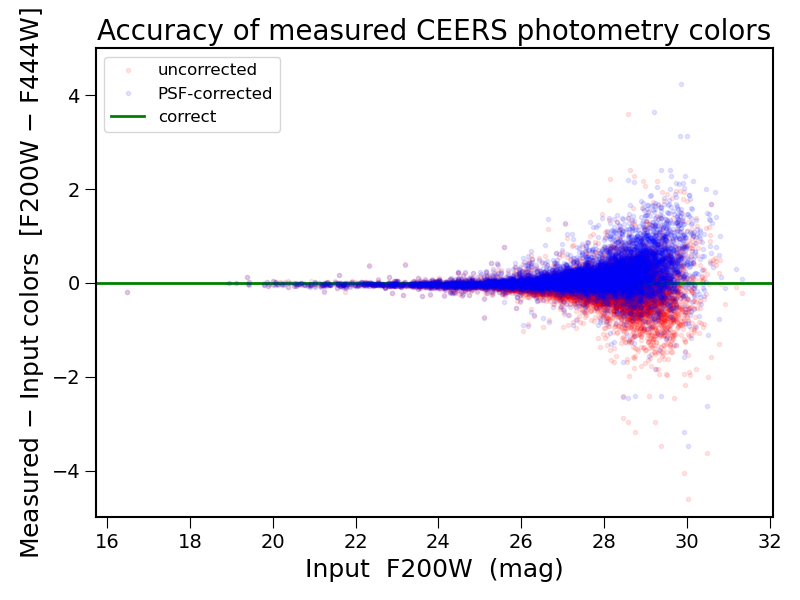

In [20]:
# Input vs. Output Color

filt1, filt2 = 'F200W F444W'.split()

input_mag1 = input_catalog_matched['NIRCam_%s' % filt1]
input_mag2 = input_catalog_matched['NIRCam_%s' % filt2]

output_mag1 = output_catalog_matched[filt1.lower() + '_mag'].value
output_mag2 = output_catalog_matched[filt2.lower() + '_mag'].value
output_ids  = output_catalog_matched['id'].data.astype(int)

input_color  = input_mag1  - input_mag2
output_color = output_mag1 - output_mag2

output_mag1_uncor = output_mag1 + 0
PSF_flux_cor = output_catalog_matched[filt2.lower()+'_PSF_flux_cor']
PSF_mag_cor = -2.5 * np.log10(PSF_flux_cor)
output_mag2_uncor = output_mag2 - PSF_mag_cor.value
output_color_uncor = output_mag1_uncor - output_mag2_uncor

plt.figure(figsize=(8, 6))

plt.plot(input_mag1, output_color_uncor - input_color, 'r.', alpha=0.1, label='uncorrected', zorder=-10)
plt.plot(input_mag1, output_color       - input_color, 'b.', alpha=0.1, label='PSF-corrected')

plt.axhline(0, c='g', label='correct', zorder=-10)
plt.xlabel('Input  ' + filt1 + '  (mag)')
plt.ylabel('Measured $-$ Input colors  [%s $-$ %s]' % (filt1, filt2))
plt.ylim(-5,5)
#plt.xlim(15.9, 30.4)

plt.title('Accuracy of measured CEERS photometry colors')

plt.legend();
#plt.savefig('CEERS_colors_%s-%s.png' % (filt1, filt2))

# Input vs. Output Redshift

In [21]:
# Plot log(1+z)

def z2log(z):
    return np.log10(1+z)

def log2z(log1z):
    return 10 ** log1z - 1

In [22]:
zin =   input_catalog_matched['redshift']
zout =  output_catalog_matched['z_phot']
zrisk = output_catalog_matched['z_phot_risk']
size = 16 * (np.max(zrisk) - zrisk)
size = size * (zrisk > -0.1)  # set to 0 and don't show if risk = -1
mag = output_catalog_matched['f200w_mag']
np.max(zrisk), np.min(zrisk), np.max(size), np.min(size)

(0.8577792, -1.0, 13.6811019264, 0.0)

<IPython.core.display.Javascript object>


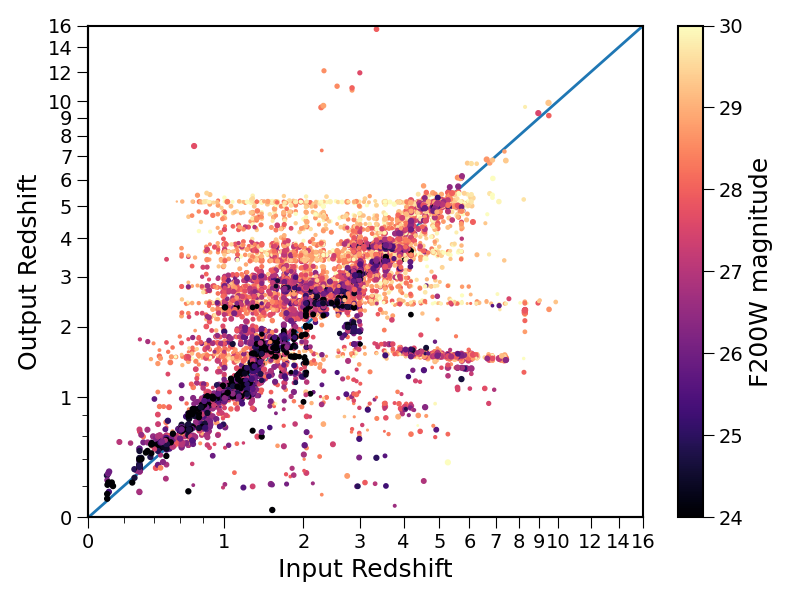

/var/folders/y3/vsjr6j554mnfpgy_m1xrnckm0003tz/T/ipykernel_26868/3899910494.py:4: RuntimeWarning: divide by zero encountered in log10
  return np.log10(1+z)


Text(0, 0.5, 'Output Redshift')

In [23]:
fig, ax = plt.subplots(figsize=(8, 6))

zmax = 16
plt.plot([0,z2log(zmax)],[0,z2log(zmax)], zorder=-10)
scat = plt.scatter(z2log(zin), z2log(zout), c=mag, s=size, alpha=1, vmin=24, vmax=30, cmap='magma')
cbar = plt.colorbar(scat)
cbar.set_label('F200W magnitude')
plt.xlim(0,z2log(zmax))
plt.ylim(0,z2log(zmax))

ztx = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 12, 14, 16]
ztx_minor = np.arange(0.2,1,0.2)

ax.xaxis.tick_top()
plt.tick_params(axis='x', which='both', top=False, labeltop=False)
sec_xax = ax.secondary_xaxis('bottom', functions=(log2z, z2log))
sec_xax.set_xticks(ztx)
sec_xax.set_xticks(ztx_minor, minor=True)
sec_xax.set_xlabel('Input Redshift')

ax.yaxis.tick_right()
plt.tick_params(axis='y', which='both', right=False, labelright=False)
sec_yax = ax.secondary_yaxis('left', functions=(log2z, z2log))
sec_yax.set_yticks(ztx)
sec_yax.set_yticks(ztx_minor, minor=True)
sec_yax.set_ylabel('Output Redshift')
#plt.savefig('CEERS_EAZY_zphot.png')

# Inspect individual object

In [ ]:
# Input haloid 18069872, galid 1, redshift = 8.291995
# Output id 1023

In [24]:
z8 = input_catalog_matched['redshift'] > 8
input_catalog_matched[z8]

haloid,galid,redshift,ra,dec,m_vir,V_vir,r_vir,mhalo,mstar,mcold,Zstar,Zcold,mstardot,sfr_ave,meanage,angular_size,ellipticity,pos_angle,sersic_index,UV1500_rest,UV2300_rest,UV2800_rest,galex_FUV,galex_NUV,acsf435w,acsf606w,acsf775w,acsf814w,acsf850lp,wfc3f275w,wfc3f336w,wfc3f105w,wfc3f125w,wfc3f160w,NIRCam_F070W,NIRCam_F090W,NIRCam_F115W,NIRCam_F150W,NIRCam_F200W,NIRCam_F277W,NIRCam_F356W,NIRCam_F444W,NIRCam_F140M,NIRCam_F162M,NIRCam_F182M,NIRCam_F210M,NIRCam_F250M,NIRCam_F335M,NIRCam_F360M,NIRCam_F410M,NIRCam_F430M,NIRCam_F460M,NIRCam_F480M,irac_ch1,irac_ch2,irac_ch3,irac_ch4,MIRI_F560W,MIRI_F770W,MIRI_F1000W,MIRI_F1130W,MIRI_F1280W,MIRI_F1500W,MIRI_F1800W,MIRI_F2100W,MIRI_F2550W
int64,int64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64
18070021,1,8.29834,214.95688,52.928619,6.1489676,138.49927,0.013763829,6.1489676,0.030940765,0.20669273,0.18665432,0.26055479,5.935035,3.832643,0.073974078,0.069355,0.949153,261.256292,1.0,-16.576227,-17.156049,-17.358509,99.9,254.30751,54.056228,54.39915,49.225276,42.510538,39.367866,216.069933,148.622144,32.792854,30.990979,30.512022,67.483588,38.878298,31.56618,30.543754,30.17796,29.832797,29.289302,28.799268,30.650043,30.39871,30.266219,30.104569,29.928077,29.561304,29.184164,28.929348,28.863961,28.515918,28.653796,29.31575675777882,28.84149071008548,28.56115715917847,28.190785346662494,1.3443221e-08,1.8704242e-08,2.3719589e-08,2.5298894e-08,2.6823156e-08,2.9023208e-08,2.6744265e-08,2.2772883e-08,1.7656566e-08
18069872,1,8.291995,214.98962,52.949032,4.9823009,129.07498,0.01284038,4.9823009,0.016767834,0.15800407,0.1326365,0.2061737,4.4249496,2.4479699,0.059929671,0.060285,0.017198,10.641557,1.0,-19.91723,-19.692511,-19.54169,114.80568,68.744469,49.4393,49.702094,43.208485,37.428213,34.631759,65.427204,63.026532,28.965418,27.406737,27.37257,60.184151,34.161945,27.868679,27.350208,27.505107,27.748002,27.700804,27.541041,27.32864,27.378303,27.468195,27.538206,27.679694,27.856952,27.615243,27.580349,27.612479,27.263042,27.568409,27.72300560563233,27.66034668454435,27.767156392016673,27.841070867870023,2.8451681e-08,2.6512315e-08,2.5136309e-08,2.3860608e-08,2.3054874e-08,2.217383e-08,1.8342567e-08,1.4676931e-08,1.0543229e-08
10606430,1,8.948092,215.00336,52.956993,3.8628319,122.68638,0.011019095,3.8628319,0.01675229,0.14831708,0.13147954,0.19659838,3.8432439,2.3338474,0.063459497,0.063519,0.229594,79.219326,1.0,-19.865005,-19.633431,-19.482694,114.54572,69.704783,52.104644,52.864309,51.528294,43.909599,37.878405,66.997771,65.376423,35.288082,27.999575,27.498672,77.929286,39.578777,28.868879,27.482507,27.633608,27.870739,27.959705,27.70206,27.436536,27.534489,27.592215,27.671156,27.812816,28.041804,28.011258,27.723803,27.728224,27.778625,27.603035,27.99297901567244,27.776986938497778,27.900984928610555,27.981061550016705,2.5175838e-08,2.3296091e-08,2.26492e-08,2.1524417e-08,2.0716026e-08,2.0150926e-08,1.7847973e-08,1.4707853e-08,1.0089894e-08
9467779,1,9.480299,214.93442,52.908592,1.3713864,89.163154,0.00740666,1.3713864,0.0018228742,0.044729041,0.051111232,0.078587431,0.64270283,0.29875952,0.037137234,0.045332,0.761799,228.658902,1.0,-17.99652,-17.701856,-17.521023,91.882799,66.107603,59.593379,60.38569,58.985043,52.578512,43.880799,64.303135,65.715334,38.910662,30.436548,29.422421,93.079313,46.931387,33.350227,29.400748,29.59266,29.868616,30.110098,29.944525,29.358099,29.475056,29.533755,29.641032,29.792158,30.075079,30.163014,29.944091,29.898708,29.935244,30.011298,30.12946805722875,29.9678851535338,30.16901342071658,30.347083

In [25]:
output_catalog_matched[z8]

id,x,y,ra,dec,area,a,b,fwhm,ellipticity,orientation,gini,kron_radius,local_background,total_flux_cor,f115w_flux,f115w_fluxerr,f115w_mag,f115w_magerr,f150w_flux,f150w_fluxerr,f150w_mag,f150w_magerr,f200w_flux,f200w_fluxerr,f200w_mag,f200w_magerr,f277w_flux,f277w_fluxerr,f277w_mag,f277w_magerr,f356w_flux,f356w_fluxerr,f356w_mag,f356w_magerr,f444w_flux,f444w_fluxerr,f444w_mag,f444w_magerr,f277w_PSF_flux_cor,f356w_PSF_flux_cor,f444w_PSF_flux_cor,nusefilt,z_ml,z_ml_chi2,z_ml_risk,lc_min,lc_max,z_phot,z_phot_chi2,z_phot_risk,z_min_risk,min_risk,z_raw_chi2,raw_chi2,z025,z160,z500,z840,z975,restU,restU_err,restB,restB_err,restV,restV_err,restJ,restJ_err,dL,Lv,mass,sfr,LIR,energy_abs,Av,lw_age_V,MLv
int64,float64,float64,float64,float64,int64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,int64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64
665,3516.1116,443.3148,214.9568788,52.9286175,9,0.9479,0.6874,1.9498,0.2748,-66.897,0.0941,3.2924,0.001,3.5241,-0.0032,0.0017,99.0,32.2021,0.0044,0.0022,29.7824,0.4425,0.0044,0.0018,29.79,0.3681,0.0035,0.0029,30.025977809544294,0.6448909345123076,0.0071,0.0024,29.2652086412741,0.3185971320869151,0.0186,0.0053,28.22615805181846,0.2734475704616294,1.5712,1.8013,1.9465,6,9.6367655,3.6827118,0.6210643,11543.0,44036.7,9.6367655,3.6827118,0.6210643,10.358318,0.5830039,9.912951,3.6351,1.6323,2.6534,9.4282,11.124,14.0872,0.009,0.002,0.023,0.009,0.05,0.057,1.046,10.096,100000.0,2890000000.0,17200000000.0,0.674,4660000000.0,0.0,1.93,-99.0,5.96
1023,6918.0936,624.0345,214.9896163,52.9490311,63,1.9515,1.923,4.562,0.0146,-71.8171,0.3247,1.9703,-0.0003,1.4301,0.0265,0.0019,27.8417,0.0762,0.0376,0.0024,27.4635,0.0666,0.0362,0.002,27.503,0.0584,0.0314,0.0022,27.65893312239472,0.0742861213549345,0.0301,0.0017,27.703060204251948,0.06114710462242001,0.0323,0.0034,27.62589086420278,0.10893869555955937,1.0554,1.1185,1.187,6,2.2453394,0.60168344,0.09675016,11543.0,44036.7,2.2453394,0.60168344,0.09675016,2.1897748,0.08261886,2.2542126,0.6084,1.7971,2.0309,2.1927,2.2966,2.4227,0.028,0.002,0.034,0.003,0.033,0.002,0.031,0.002,18000.0,204000000.0,26400000.0,0.106,183000000.0,0.0,0.1,-99.0,0.13
1259,8291.2233,746.305,215.0033538,52.9569983,67,2.5112,1.8495,5.1931,0.2635,-63.6633,0.2916,2.9058,0.0014,1.7705,0.0072,0.0024,29.2628,0.3114,0.043,0.003,27.3172,0.0742,0.0361,0.0025,27.506,0.0735,0.0312,0.0029,27.664035800361884,0.09783647092085274,0.0312,0.0023,27.666044497106913,0.07616003294377233,0.0407,0.0046,27.374720327043246,0.11525334457550207,1.1236,1.1877,1.2624,6,9.264058,18.06821,0.113885075,11543.0,44036.7,9.264058,18.06821,0.113885075,9.380721,0.10735618,9.2774315,18.0429,2.3801,9.1044,9.2959,9.9084,10.0933,0.034,0.003,0.043,0.006,0.044,0.066,0.038,0.004,95000.0,2430000000.0,297000000.0,1.275,2190000000.0,0.0,0.07,-99.0,0.12
1354,636.4046,790.6888,214.9344132,52.908598,7,1.0042,0.4753,1.8499,0.5267,82.0489,0.1058,2.8336,-0.0003,3.2789,-0.0031,0.0014,99.0,32.3338,0.0089,0.0018,29.0231,0.2005,0.007,0.0015,29.2841,0.2092,0.0077,0.0026,29.19004020654315,0.3208671284839327,0.0069,0.0026,29.298940849746327,0.35019923482478704,0.0169,0.0069,28.332805205084796,0.37066727860270643,1.8933,2.4338,3.2203,6,9.888536,6.0119424,0.07709134,11543.0,44036.7,9.888536,6.0119424,0.07709134,9.912951,0.07629257,9.912951,5.9953,3.0455,9.5904,9.9366,10.4018,10.958,0.01,0.003,0.024,0.015,0.075,0.075,1.114,1.573,100000.0,4470000000.0,33200000000.0,1.935,11500000000.0,0.0,2.67,-99.0,7.43
1430,6062.7533,836.3597,214.984073,52.9424905,23,1.4641,1.119,3.0684,0.2357,62.4414,0.1321,2.6108,0.0001

In [26]:
# for SED plot, automatic secondary axis magnitudes don't work when fluxes extend to negative values
# so I wrote my own code to do this

def AB2uJy(mAB):
    m = mAB * u.ABmag
    f = m.to(u.uJy)
    return f.value

def uJy2AB(F_uJy):
    f = F_uJy * u.uJy
    m = f.to(u.ABmag)
    return m.value

def AB2nJy(mAB):
    m = mAB * u.ABmag
    f = m.to(u.nJy)
    return f.value

def nJy2AB(F_nJy):
    f = F_nJy * u.nJy
    m = f.to(u.ABmag)
    return m.value

def add_magnitude_axis(ax, flux_units=u.nJy, plothuge=True):
    ylo, yhi = plt.ylim() * flux_units
    maghi = yhi.to(u.ABmag).value
    ytx1 = np.ceil(maghi * 10) / 10.  # 24.101 -> 24.2
    ytx2 = np.ceil(maghi)  # 24.1 -> 25

    fpart = ytx1 - int(ytx1)  # 0.2
    if np.isclose(fpart, 0) or np.isclose(fpart, 0.9):
        ytx1 = []
    elif np.isclose(fpart, 0.1) or np.isclose(fpart, 0.2):
        ytx1 = np.array([ytx1, ytx2-0.7, ytx2-0.5, ytx2-0.3])  # 24.1, 24.3, 24.5, 24.7
    elif np.isclose(fpart, 0.3) or np.isclose(fpart, 0.4):
        ytx1 = np.array([ytx1, ytx2-0.5, ytx2-0.3])  # 24.3, 24.5, 24.7
    elif np.isclose(fpart, 0.5):
        ytx1 = np.array([ytx1, ytx2-0.3])  # 24.5, 24.7
    elif np.isclose(fpart, 0.6):
        ytx1 = np.array([ytx1, ytx2-0.2])  # 24.6, 24.8

    if isinstance(ytx1, float):
        ytx1 = np.array([ytx1])

    if plothuge:
        ytx3 = ytx2 + np.array([0, 0.2, 0.5, 1, 2])
    else:
        ytx3 = ytx2 + np.array([0, 0.2, 0.5, 1, 1.5, 2, 3])

    ytx2 = np.array([ytx2])
    ytx = np.concatenate([ytx1, ytx3])
    yts = ['%g' % mag for mag in ytx]

    ytx = (ytx * u.ABmag).to(flux_units).value
    
    ax2 = ax.twinx()
    ax.yaxis.set_label_position('left')
    ax2.yaxis.set_label_position('right')
    ax.yaxis.tick_left()
    ax2.yaxis.tick_right()

    ax2.set_yticks(ytx)
    ax2.set_yticklabels(yts)
    ax2.set_ylabel('Magnitude (AB)')
    ax2.set_ylim(ylo.value, yhi.value)
    ax2.set_zorder(-100)  # interactive cursor will output left axis ax

In [27]:
z8ids = output_catalog_matched[z8]['id']
output_id = z8ids[1]
matched_index = list(output_catalog_matched['id']).index(output_id)
input_obj  = input_catalog_matched[matched_index]
output_obj = output_catalog_matched[matched_index]
#segm_obj = segm.segments[segm.get_index(output_id)]
output_obj

id,x,y,ra,dec,area,a,b,fwhm,ellipticity,orientation,gini,kron_radius,local_background,total_flux_cor,f115w_flux,f115w_fluxerr,f115w_mag,f115w_magerr,f150w_flux,f150w_fluxerr,f150w_mag,f150w_magerr,f200w_flux,f200w_fluxerr,f200w_mag,f200w_magerr,f277w_flux,f277w_fluxerr,f277w_mag,f277w_magerr,f356w_flux,f356w_fluxerr,f356w_mag,f356w_magerr,f444w_flux,f444w_fluxerr,f444w_mag,f444w_magerr,f277w_PSF_flux_cor,f356w_PSF_flux_cor,f444w_PSF_flux_cor,nusefilt,z_ml,z_ml_chi2,z_ml_risk,lc_min,lc_max,z_phot,z_phot_chi2,z_phot_risk,z_min_risk,min_risk,z_raw_chi2,raw_chi2,z025,z160,z500,z840,z975,restU,restU_err,restB,restB_err,restV,restV_err,restJ,restJ_err,dL,Lv,mass,sfr,LIR,energy_abs,Av,lw_age_V,MLv
int64,float64,float64,float64,float64,int64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,int64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64
1023,6918.0936,624.0345,214.9896163,52.9490311,63,1.9515,1.923,4.562,0.0146,-71.8171,0.3247,1.9703,-0.0003,1.4301,0.0265,0.0019,27.8417,0.0762,0.0376,0.0024,27.4635,0.0666,0.0362,0.002,27.503,0.0584,0.0314,0.0022,27.65893312239472,0.0742861213549345,0.0301,0.0017,27.703060204251948,0.06114710462242001,0.0323,0.0034,27.62589086420278,0.10893869555955937,1.0554,1.1185,1.187,6,2.2453394,0.60168344,0.09675016,11543.0,44036.7,2.2453394,0.60168344,0.09675016,2.1897748,0.08261886,2.2542126,0.6084,1.7971,2.0309,2.1927,2.2966,2.4227,0.028,0.002,0.034,0.003,0.033,0.002,0.031,0.002,18000.0,204000000.0,26400000.0,0.106,183000000.0,0.0,0.1,-99.0,0.13


In [28]:
input_obj

haloid,galid,redshift,ra,dec,m_vir,V_vir,r_vir,mhalo,mstar,mcold,Zstar,Zcold,mstardot,sfr_ave,meanage,angular_size,ellipticity,pos_angle,sersic_index,UV1500_rest,UV2300_rest,UV2800_rest,galex_FUV,galex_NUV,acsf435w,acsf606w,acsf775w,acsf814w,acsf850lp,wfc3f275w,wfc3f336w,wfc3f105w,wfc3f125w,wfc3f160w,NIRCam_F070W,NIRCam_F090W,NIRCam_F115W,NIRCam_F150W,NIRCam_F200W,NIRCam_F277W,NIRCam_F356W,NIRCam_F444W,NIRCam_F140M,NIRCam_F162M,NIRCam_F182M,NIRCam_F210M,NIRCam_F250M,NIRCam_F335M,NIRCam_F360M,NIRCam_F410M,NIRCam_F430M,NIRCam_F460M,NIRCam_F480M,irac_ch1,irac_ch2,irac_ch3,irac_ch4,MIRI_F560W,MIRI_F770W,MIRI_F1000W,MIRI_F1130W,MIRI_F1280W,MIRI_F1500W,MIRI_F1800W,MIRI_F2100W,MIRI_F2550W
int64,int64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64
18069872,1,8.291995,214.98962,52.949032,4.9823009,129.07498,0.01284038,4.9823009,0.016767834,0.15800407,0.1326365,0.2061737,4.4249496,2.4479699,0.059929671,0.060285,0.017198,10.641557,1.0,-19.91723,-19.692511,-19.54169,114.80568,68.744469,49.4393,49.702094,43.208485,37.428213,34.631759,65.427204,63.026532,28.965418,27.406737,27.37257,60.184151,34.161945,27.868679,27.350208,27.505107,27.748002,27.700804,27.541041,27.32864,27.378303,27.468195,27.538206,27.679694,27.856952,27.615243,27.580349,27.612479,27.263042,27.568409,27.72300560563233,27.66034668454435,27.767156392016673,27.841070867870023,2.8451681e-08,2.6512315e-08,2.5136309e-08,2.3860608e-08,2.3054874e-08,2.217383e-08,1.8342567e-08,1.4676931e-08,1.0543229e-08


# SED plot

In [29]:
input_mags = np.array([input_obj['NIRCam_'+filt.upper()] for filt in filters])
input_fluxes = np.array([(mag*u.ABmag).to(u.uJy).value for mag in input_mags])
#input_fluxes     = np.array([input_obj['NIRCam_'+filt.upper()] for filt in filters])
output_fluxes    = np.array([output_obj[filt+'_flux']    for filt in filters])
output_flux_errs = np.array([output_obj[filt+'_fluxerr'] for filt in filters])

In [30]:
# Measured flux does not recover total input flux
# Given known simulation input, determine what fraction of the flux was recovered
# Use this to scale measured SED to input SED for comparison, plotted below

# Scale output to input flux using F200W only (other filters may have incorrect flux corrections)

filt = 'f200w'
ifilt = filters.index(filt)
#flux_scale_factor = output_obj[filt+'_flux'] / (input_obj['NIRCam_'+filt.upper()]) * u.ABmag.to(u.uJy)
flux_scale_factor = output_fluxes[ifilt] / input_fluxes[ifilt]
#flux_factor = 1
flux_factor = 1 / flux_scale_factor  # input / output
print('%d%% of input flux recovered by photutils' % (100 * flux_scale_factor))

100% of input flux recovered by photutils


100% of input flux recovered by photutils


<IPython.core.display.Javascript object>


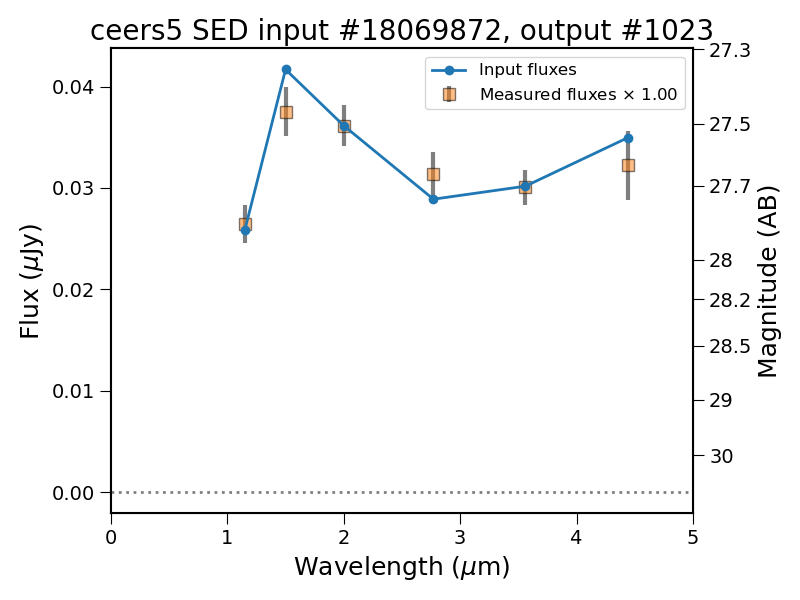

Text(0.5, 1.0, 'ceers5 SED input #18069872, output #1023')

In [31]:
matched_index = list(output_catalog_matched['id']).index(output_id)
input_obj  = input_catalog_matched[matched_index]
output_obj = output_catalog_matched[matched_index]
#segm_obj = segm.segments[segm.get_index(output_id)]
#output_obj

input_mags = np.array([input_obj['NIRCam_'+filt.upper()] for filt in filters])
input_fluxes = np.array([(mag*u.ABmag).to(u.uJy).value for mag in input_mags])
#input_fluxes     = np.array([input_obj['NIRCam_'+filt.upper()] for filt in filters])
output_fluxes    = np.array([output_obj[filt+'_flux']    for filt in filters])
output_flux_errs = np.array([output_obj[filt+'_fluxerr'] for filt in filters])

# Measured flux does not recover total input flux
# Given known simulation input, determine what fraction of the flux was recovered
# Use this to scale measured SED to input SED for comparison, plotted below

# Scale output to input flux using F200W only (other filters may have incorrect flux corrections)

filt = 'f200w'
ifilt = filters.index(filt)
#flux_scale_factor = output_obj[filt+'_flux'] / (input_obj['NIRCam_'+filt.upper()]) * u.ABmag.to(u.uJy)
flux_scale_factor = output_fluxes[ifilt] / input_fluxes[ifilt]
#flux_factor = 1
flux_factor = 1 / flux_scale_factor  # input / output
print('%d%% of input flux recovered by photutils' % (100 * flux_scale_factor))

fig, ax = plt.subplots(figsize=(8, 6))

plt.plot(wavelengths, input_fluxes, 'o-', label='Input fluxes', zorder=10, scaley=False)

label = 'Measured fluxes'
if flux_factor != 1.0:
    label += ' $\\times$ %.2f' % flux_factor
plt.errorbar(wavelengths.value, output_fluxes * flux_factor, output_flux_errs * flux_factor,
             ms=8, marker='s', mfc=mpl_colors[1], c='k', lw=3, alpha=0.5, ls='none', label=label)

if 0:
    label = 'Measured fluxes before PSF corrections $\\times$ %.2f' % flux_factor
    plt.errorbar(wavelengths.value, output_fluxes * flux_factor / PSF_flux_corrections, output_flux_errs * flux_factor,
                 ms=8, marker='s', mfc='r', c='k', lw=3, alpha=0.5, ls='none', label=label, zorder=-10)

plt.legend()
#plt.axhline(0, c='k', ls=':')
plt.xlim(0, 5)
#plt.ylim(15, 70)
plt.xlabel('Wavelength ($\\mu$m)')
plt.ylabel('Flux ($\\mu$Jy)')
#plt.ylabel('Flux (nJy)')
if 0:   # log flux
    plt.semilogy()
    ax.yaxis.set_major_formatter(ticker.FormatStrFormatter("%g"))
    ax.yaxis.set_minor_formatter(ticker.FormatStrFormatter("%g"))

    # Add AB magnitudes as secondary x-axis at right
    # (Note this breaks if any fluxes are negative)
    # https://matplotlib.org/gallery/subplots_axes_and_figures/secondary_axis.html#sphx-glr-gallery-subplots-axes-and-figures-secondary-axis-py

    # secondary_axis = add_magnitude_axis(ax, flux_units)
    #secax = ax.secondary_yaxis('right', functions=(nJy2AB, AB2nJy))
    secax = ax.secondary_yaxis('right', functions=(uJy2AB, AB2uJy))
    secax.set_ylabel('magnitude (AB)')
    secax.yaxis.set_major_formatter(ticker.FormatStrFormatter("%g"))
    secax.yaxis.set_minor_formatter(ticker.FormatStrFormatter("%g"))

else: # plot linear flux
    plt.axhline(0, ls=':', c='0.50')
    secondary_axis = add_magnitude_axis(ax, u.uJy)

#plt.ylim(0.02, 0.05)

plt.title(field + ' SED input #%d, output #%d'  % (input_obj['haloid'], output_obj['id']))
#plt.savefig(field + '_SED_input%d_output%d.png' % (input_obj['haloid'], output_obj['id']))

# Look at the object in all filters

In [32]:
import photutils

In [35]:
#image_files_list = glob('../images/*_drz.fits')  
image_files_list = glob('../images/*_sci.fits.gz')
image_files_list = list(np.sort(image_files_list))
filters = [image_file.split('_')[-2] for image_file in image_files_list]

# Remove stacked image _total_sci.fits.gz if present
exclude_total = [filt != 'total' for filt in filters]
image_files_list = list(np.array(image_files_list)[exclude_total])
filters = list(np.array(filters)[exclude_total])

image_files_dict = {}
wavelengths = np.array([int(filt[1:4]) / 100 for filt in filters]) * u.um  # e.g., F115W = 1.15 microns
for i, filt in enumerate(filters):
    image_files_dict[filt] = image_files_list[i]
    print(filt, image_files_dict[filt])

field = os.path.basename(image_files_dict[filt]).split('_')[0]
field

f115w ../images/ceers5_f115w_sci.fits.gz
f150w ../images/ceers5_f150w_sci.fits.gz
f200w ../images/ceers5_f200w_sci.fits.gz
f277w ../images/ceers5_f277w_sci.fits.gz
f356w ../images/ceers5_f356w_sci.fits.gz
f444w ../images/ceers5_f444w_sci.fits.gz


'ceers5'

In [36]:
idata = 1        # extension of HDU where data lives

In [39]:
# Segmentation map
segmfile = '../phot3/ceers5_total_detections_segm.fits.gz'
segm = fits.open(segmfile)[0].data
segm = photutils.segmentation.SegmentationImage(segm)

In [41]:
# Select object with id from catalog
output_index = segm.get_index(output_id)
output_obj = output_catalog[output_index]
segmobj = segm.segments[segm.get_index(output_id)]
#print(output_id, output_obj['F090W_mag'], output_obj['F200W_mag'])

In [59]:
segmobj.slices

(slice(620, 629, None), slice(6914, 6923, None))

In [56]:
segmobj.bbox.extent

(6913.5, 6922.5, 619.5, 628.5)

In [68]:
from PIL import Image

field = 'ceers5'
infile = '../color/%s_color.png' % field
im = Image.open(infile)
color_image = np.asarray(im)
color_image = color_image[::-1]

<IPython.core.display.Javascript object>


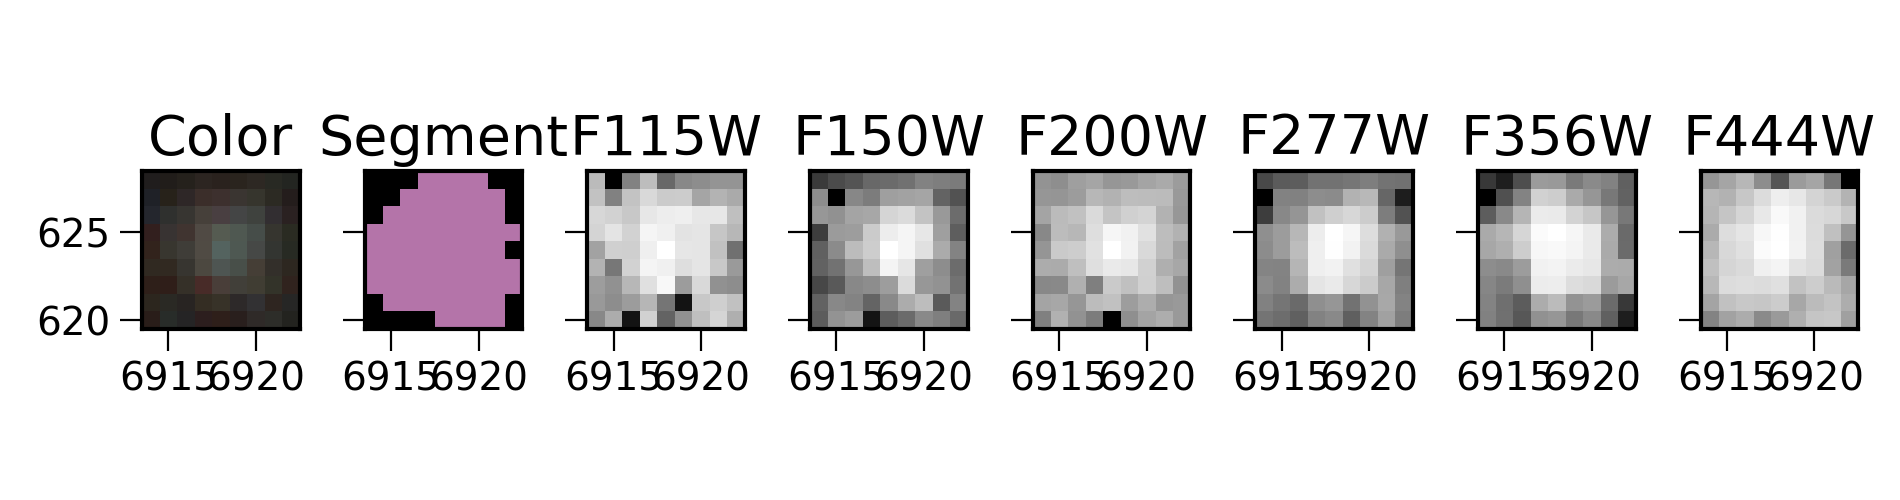

In [70]:
fig, ax = plt.subplots(1, len(filters)+2, figsize=(9.5, 2.5), sharex=True, sharey=True)

ax[0].imshow(color_image[segmobj.slices], origin='lower', extent=segmobj.bbox.extent)
ax[0].set_title('Color')

cmap = segm.make_cmap(seed=12345)  # ERROR
ax[1].imshow(segm.data[segmobj.slices], origin='lower', extent=segmobj.bbox.extent, cmap=cmap,
                interpolation='nearest')
ax[1].set_title('Segment')

for i, filt in enumerate(filters):
    filt = filters[i]

    # Show data on top row
    data = fits.open(image_files_dict[filt])[idata].data
    stamp = data[segmobj.slices]
    norm = ImageNormalize(stretch=SqrtStretch())  # scale each filter individually
    ax[i+2].imshow(stamp, extent=segmobj.bbox.extent, cmap='Greys_r', norm=norm, origin='lower')
    ax[i+2].set_title(filt.upper())